# CNN Training

Target of this code is to train a CNN network to classify images of a digital readout to the digits 0 to 9. Additionally a category "NaN" is introduced, to mark images that are not amibiguous.

### Preparing the training
* First all libraries are loaded
    * It is assumed, that they are installed during the Python setup
* matplotlib is set to print the output inline in the jupyter notebook

In [1]:
########### Basic Parameters for Running: ################################
    
TFliteNamingAndVersion = "dig1320s1"   # Used for tflite Filename
Training_Percentage = 0.0              # 0.0 = Use all Images for Training
Epoch_Anz = 500

##########################################################################


import tensorflow as tf
import matplotlib.pyplot as plt
import glob
import os
import numpy as np
from sklearn.utils import shuffle
from tensorflow.python import keras
from tensorflow.python.keras import Sequential
from tensorflow.python.keras.layers import Dense, InputLayer, Conv2D, MaxPool2D, Flatten, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import History 
from tensorflow.keras.utils import to_categorical
from PIL import Image 
from pathlib import Path

loss_ges = np.array([])
val_loss_ges = np.array([])

%matplotlib inline
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

### Load training data
* The data is expected in the "Input_dir"
* Inside subdirectories are expected from -1, 0, 1, ... 9 in which the pictures are sorted according to their values (=category)
* Picture size must be 20x32 with 3 color channels (RGB)
* The filename can be arbitrary

* The images are stored in the x_data[]
* The expected category for each image in the corresponding y_data[]

* The last step is a shuffle (from sklearn.utils) and split the data into training and validation data

In [2]:
Input_dir='ziffer_sortiert_resize'

files = glob.glob(Input_dir + '/*.jpg')
x_data = []
y_data = []

for aktfile in files:
    base = os.path.basename(aktfile)
    target = base[0:1]
    if target == "N":
        category = 10                # NaN does not work --> convert to 10
    else:
        category = int(target)
    test_image = Image.open(aktfile)
    test_image = np.array(test_image, dtype="float32")
    x_data.append(test_image)
    y_data.append(np.array([category]))

x_data = np.array(x_data)
y_data = np.array(y_data)
y_data = to_categorical(y_data, 11)
print(x_data.shape)
print(y_data.shape)

x_data, y_data = shuffle(x_data, y_data)

if (Training_Percentage > 0):
    X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=Training_Percentage)
else:
    X_train = x_data
    y_train = y_data

(1582, 32, 20, 3)
(1582, 11)


### Define the model

The layout of the network ist a typcial CNN network with alternating **Conv2D** and **MaxPool2D** layers. Finished after **flattening** with additional **Dense** layer.

#### Important
* Shape of the input layer: (32, 20, 3)
* Number of output layers: 11
* As loss function "categorical_crossentropy" is choosen, as it is a categories task

In [3]:
model = Sequential()
model.add(BatchNormalization(input_shape=(32,20,3)))
model.add(Conv2D(32, (3, 3), padding='same', activation="relu"))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(64, (3, 3), padding='same', activation="relu"))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(64, (3, 3), padding='same', activation="relu"))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(256,activation="relu"))
model.add(Dense(11, activation = "softmax"))
model.summary()

model.compile(loss=keras.losses.categorical_crossentropy, optimizer=tf.keras.optimizers.Adadelta(learning_rate=1.0, rho=0.95), metrics = ["accuracy"])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 32, 20, 3)         12        
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 20, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 10, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 10, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 5, 64)          36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 2, 64)          0

# Training
The input pictures are randomly scattered for brightness, pixel shift variations and rotation angle. This is implemented with a ImageDataGenerator.


In [4]:
Batch_Size = 4
Shift_Range = 1
Brightness_Range = 0.2
Rotation_Angle = 5
ZoomRange = 0.3

datagen = ImageDataGenerator(width_shift_range=[-Shift_Range,Shift_Range], 
                             height_shift_range=[-Shift_Range,Shift_Range],
                             brightness_range=[1-Brightness_Range,1+Brightness_Range],
                             zoom_range=[1-ZoomRange, 1+ZoomRange],
                             rotation_range=Rotation_Angle)

if (Training_Percentage > 0):
    train_iterator = datagen.flow(x_data, y_data, batch_size=Batch_Size)
    validation_iterator = datagen.flow(X_test, y_test, batch_size=Batch_Size)
    history = model.fit(train_iterator, validation_data = validation_iterator, epochs = Epoch_Anz)
else:
    train_iterator = datagen.flow(x_data, y_data, batch_size=Batch_Size)
    history = model.fit(train_iterator, epochs = Epoch_Anz)



Epoch 1/500
396/396 [==============================] - 5s 11ms/step - loss: 2.2502 - accuracy: 0.2714
Epoch 2/500
396/396 [==============================] - 4s 11ms/step - loss: 1.4324 - accuracy: 0.5466
Epoch 3/500
396/396 [==============================] - 4s 11ms/step - loss: 0.9175 - accuracy: 0.7037
Epoch 4/500
396/396 [==============================] - 4s 11ms/step - loss: 0.6859 - accuracy: 0.7837
Epoch 5/500
396/396 [==============================] - 5s 12ms/step - loss: 0.6486 - accuracy: 0.8005
Epoch 6/500
396/396 [==============================] - 5s 12ms/step - loss: 0.4533 - accuracy: 0.8587
Epoch 7/500
396/396 [==============================] - 5s 11ms/step - loss: 0.4232 - accuracy: 0.8834
Epoch 8/500
396/396 [==============================] - 5s 12ms/step - loss: 0.3349 - accuracy: 0.9005
Epoch 9/500
396/396 [==============================] - 4s 11ms/step - loss: 0.3885 - accuracy: 0.8959
Epoch 10/500
396/396 [==============================] - 4s 11ms/step - loss: 0.306

396/396 [==============================] - 4s 11ms/step - loss: 0.0441 - accuracy: 0.9895
Epoch 80/500
396/396 [==============================] - 4s 10ms/step - loss: 0.0989 - accuracy: 0.9836 0s - loss:
Epoch 81/500
396/396 [==============================] - 4s 11ms/step - loss: 0.0990 - accuracy: 0.9781
Epoch 82/500
396/396 [==============================] - 4s 11ms/step - loss: 0.0564 - accuracy: 0.9814
Epoch 83/500
396/396 [==============================] - 4s 11ms/step - loss: 0.0403 - accuracy: 0.9810
Epoch 84/500
396/396 [==============================] - 4s 10ms/step - loss: 0.0289 - accuracy: 0.9898 0s - loss: 0.0284 
Epoch 85/500
396/396 [==============================] - 4s 11ms/step - loss: 0.0374 - accuracy: 0.9886
Epoch 86/500
396/396 [==============================] - 5s 11ms/step - loss: 0.0868 - accuracy: 0.9831
Epoch 87/500
396/396 [==============================] - 4s 10ms/step - loss: 0.0336 - accuracy: 0.9899
Epoch 88/500
396/396 [==============================] - 

396/396 [==============================] - 4s 11ms/step - loss: 0.0604 - accuracy: 0.9891
Epoch 155/500
396/396 [==============================] - 4s 11ms/step - loss: 0.0484 - accuracy: 0.9883
Epoch 156/500
396/396 [==============================] - 4s 11ms/step - loss: 0.0472 - accuracy: 0.9896 0s - loss: 0.0480 - accu
Epoch 157/500
396/396 [==============================] - 4s 11ms/step - loss: 0.0293 - accuracy: 0.9888
Epoch 158/500
396/396 [==============================] - 4s 11ms/step - loss: 0.0333 - accuracy: 0.9927
Epoch 159/500
396/396 [==============================] - 4s 11ms/step - loss: 0.0361 - accuracy: 0.9939
Epoch 160/500
396/396 [==============================] - 4s 11ms/step - loss: 0.0229 - accuracy: 0.9943
Epoch 161/500
396/396 [==============================] - 4s 11ms/step - loss: 0.0490 - accuracy: 0.9864
Epoch 162/500
396/396 [==============================] - 4s 11ms/step - loss: 0.0117 - accuracy: 0.9960
Epoch 163/500
396/396 [==============================

396/396 [==============================] - 4s 11ms/step - loss: 0.0255 - accuracy: 0.9948
Epoch 267/500
396/396 [==============================] - 4s 11ms/step - loss: 0.0049 - accuracy: 0.9992 0s - l
Epoch 268/500
396/396 [==============================] - 4s 11ms/step - loss: 0.0453 - accuracy: 0.9938
Epoch 269/500
396/396 [==============================] - 4s 11ms/step - loss: 0.0409 - accuracy: 0.9896
Epoch 270/500
396/396 [==============================] - 4s 11ms/step - loss: 0.0172 - accuracy: 0.9956 0s - l
Epoch 271/500
396/396 [==============================] - 5s 12ms/step - loss: 0.0131 - accuracy: 0.9931
Epoch 272/500
396/396 [==============================] - 4s 11ms/step - loss: 0.0115 - accuracy: 0.9979
Epoch 273/500
396/396 [==============================] - 5s 11ms/step - loss: 0.0177 - accuracy: 0.9935
Epoch 274/500
396/396 [==============================] - 4s 11ms/step - loss: 9.4196e-04 - accuracy: 0.9999
Epoch 275/500
396/396 [==============================] - 4s 

396/396 [==============================] - 5s 11ms/step - loss: 0.0533 - accuracy: 0.9940
Epoch 355/500
396/396 [==============================] - ETA: 0s - loss: 0.0160 - accuracy: 0.99 - 5s 11ms/step - loss: 0.0160 - accuracy: 0.9959
Epoch 356/500
396/396 [==============================] - 5s 12ms/step - loss: 0.0147 - accuracy: 0.9958
Epoch 357/500
396/396 [==============================] - 4s 11ms/step - loss: 0.0253 - accuracy: 0.9959 0s - loss: 0.0254 - accuracy
Epoch 358/500
396/396 [==============================] - 4s 11ms/step - loss: 0.0051 - accuracy: 0.9990
Epoch 359/500
396/396 [==============================] - 4s 11ms/step - loss: 0.0123 - accuracy: 0.9953
Epoch 360/500
396/396 [==============================] - 4s 11ms/step - loss: 0.0222 - accuracy: 0.9957
Epoch 361/500
396/396 [==============================] - 5s 11ms/step - loss: 0.0332 - accuracy: 0.9906 
Epoch 362/500
396/396 [==============================] - 4s 11ms/step - loss: 0.0306 - accuracy: 0.9912 0s -
E

396/396 [==============================] - 4s 9ms/step - loss: 0.0086 - accuracy: 0.9992: 1s - loss: 0.0015 - accuracy: 1. - ETA: 1s - loss: 0.0026 - accuracy: 0.99 - ETA: 1s
Epoch 456/500
396/396 [==============================] - 4s 9ms/step - loss: 0.0061 - accuracy: 0.9977
Epoch 457/500
396/396 [==============================] - 4s 9ms/step - loss: 0.0465 - accuracy: 0.9919
Epoch 458/500
396/396 [==============================] - 4s 9ms/step - loss: 0.0157 - accuracy: 0.9942
Epoch 459/500
396/396 [==============================] - 4s 9ms/step - loss: 0.0012 - accuracy: 0.9997
Epoch 460/500
396/396 [==============================] - 4s 9ms/step - loss: 0.0051 - accuracy: 0.9988
Epoch 461/500
396/396 [==============================] - 3s 9ms/step - loss: 0.0471 - accuracy: 0.9934
Epoch 462/500
396/396 [==============================] - 4s 9ms/step - loss: 0.0055 - accuracy: 0.9974: 0s - loss: 0
Epoch 463/500
396/396 [==============================] - 3s 9ms/step - loss: 0.0117 - accu

### Learing result
 
* Visualization of the training and validation results

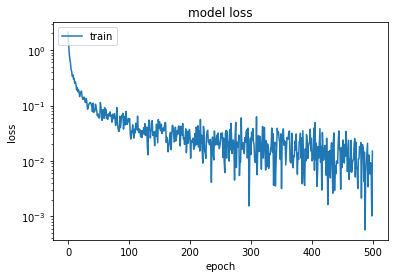

In [5]:
loss_ges = np.append(loss_ges, history.history['loss'])
plt.semilogy(history.history['loss'])

if (Training_Percentage > 0):
    val_loss_ges = np.append(val_loss_ges, history.history['val_loss'])
    plt.semilogy(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','eval'], loc='upper left')
plt.show()

### Check the model by hand

* The following code uses the trained model to check the deviation for each picture.
* x-axis walks through each pixel, y-axis shows the result

### Check each image for expected and deviation
* setting the switch "only_deviation = true" will only print the images for which the classification and the CNN-result deviates

The output contains the following information:

| Filename      | Expected Category           | Predicted Category        |
|------------- |:-----------------------------:|--------------|
| ziffer_sortiert_resize_NaN/5\Ziffer_4_0034.jpg | 4  | -1 |


ziffer_sortiert_resize\0_digit1_310410.jpg 0 3


ziffer_sortiert_resize\1_0_ht7_20210702-083138.jpg 1 -1


ziffer_sortiert_resize\3_0_ht4_20210701-194658.jpg 3 8


ziffer_sortiert_resize\3_0_ht6_20210702-055135.jpg 3 8


ziffer_sortiert_resize\3_1_ht4_20210627-124615.jpg 3 9


ziffer_sortiert_resize\3_6_ht6_20210702-044832.jpg 3 8


ziffer_sortiert_resize\6_D6_2020-08-12_22-13-27.jpg 6 8


ziffer_sortiert_resize\7_10_dig6_20210727-150532.jpg 7 -1


ziffer_sortiert_resize\7_10_ht6_20210703-133250.jpg 7 -1


ziffer_sortiert_resize\7_D7_2020-08-19_22-45-38.jpg 7 2


ziffer_sortiert_resize\7_D7_2020-08-20_15-23-28.jpg 7 2


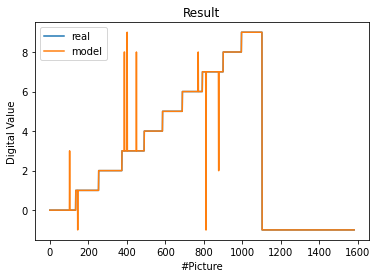

In [6]:
Input_dir='ziffer_sortiert_resize'
res = []
only_deviation = True
show_wrong_image = True

files = glob.glob(Input_dir + '/*.jpg')

for aktfile in files:
    base = os.path.basename(aktfile)
    target = base[0:1]
    if target == "N":
        zw1 = -1
    else:
        zw1 = int(target)
    expected_class = zw1
    image_in = Image.open(aktfile)
    test_image = np.array(image_in, dtype="float32")
    img = np.reshape(test_image,[1,32,20,3])
    classes = np.argmax(model.predict(img), axis=-1)
    classes = classes[0]
    if classes == 10: 
        classes = -1
    zw2 = classes
    zw3 = zw2 - zw1
    res.append(np.array([zw1, zw2, zw3]))
    if only_deviation == True:
        if str(classes) != str(expected_class):
            print(aktfile + " " + str(expected_class) +  " " + str(classes))
            if show_wrong_image == True:
                display(image_in)
    else:
        print(aktfile + " " + aktsubdir +  " " + str(classes))
        

res = np.asarray(res)


plt.plot(res[:,0])
plt.plot(res[:,1])
plt.title('Result')
plt.ylabel('Digital Value')
plt.xlabel('#Picture')
plt.legend(['real','model'], loc='upper left')
plt.show()

### Save the model

* Save the model to the file with the "h5" file format

In [7]:
FileName = TFliteNamingAndVersion

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open(FileName + ".tflite", "wb").write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\Muell\AppData\Local\Temp\tmplj0i7lj_\assets


766336

In [8]:
FileName = TFliteNamingAndVersion + "q.tflite"

import tensorflow as tf

def representative_dataset():
    for n in range(x_data[0].size):
      data = np.expand_dims(x_data[5], axis=0)
      yield [data.astype(np.float32)]
        
converter2 = tf.lite.TFLiteConverter.from_keras_model(model)
converter2.representative_dataset = representative_dataset
converter2.optimizations = [tf.lite.Optimize.DEFAULT]
converter2.representative_dataset = representative_dataset
tflite_quant_model = converter2.convert()

open(FileName, "wb").write(tflite_quant_model)
print(FileName)
Path(FileName).stat().st_size

INFO:tensorflow:Assets written to: C:\Users\Muell\AppData\Local\Temp\tmpz85q23_h\assets


INFO:tensorflow:Assets written to: C:\Users\Muell\AppData\Local\Temp\tmpz85q23_h\assets


dig1320s1q.tflite


203088

Checking the images shows, that this are border line images, which can be interpreted as a good digit or a faulty one.